# Homework 6

## By Vyanna Hill

### Chapter 12

In [1]:
#Code derived by Allen Downey from Chapter 12
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

beta = 0.333
gamma = 0.25
system = make_system(beta, gamma)

results = run_simulation(system, update_func)
print(beta, gamma, calc_total_infected(results))
print(results)

0.333 0.25 0.46716293183605073
           S         I         R
0   0.988889  0.011111  0.000000
1   0.985230  0.011992  0.002778
2   0.981296  0.012929  0.005776
3   0.977071  0.013921  0.009008
4   0.972541  0.014970  0.012488
..       ...       ...       ...
94  0.522300  0.000926  0.476775
95  0.522139  0.000855  0.477006
96  0.521990  0.000790  0.477220
97  0.521853  0.000730  0.477417
98  0.521726  0.000674  0.477600

[99 rows x 3 columns]


Exercise 1
 Write functions that take a TimeFrame object as a parameter and compute the other metrics mentioned in the book:
    The fraction of students who are sick at the peak of the outbreak.
    The day the outbreak peaks.
    The fraction of students who are sick at the end of the semester.

Note: Not all of these functions require the System object, but when you write a set of related functons, it is often convenient if they all take the same parameters.

In [2]:
#retrieve the infection stats
def peak_inf(f):
    #find I fraction of the total students infect on the peak
    return f.I.max()

def peak_day(f):
    #find peak day
    return f.I.idxmax()

def inf_end(f):
    #find I fraction at the end of the semester
    return get_last_value(f.I)
max_InfRate=peak_inf(results)
peakDay=peak_day(results)
eos_inf=inf_end(results)

print(f'At its peak, the infection rate was {max_InfRate:.0%} ')
print(f'The peak appears to be on day {peakDay}')
print(f'{eos_inf:0%} of the population is infected at the end of the semester')

At its peak, the infection rate was 4% 
The peak appears to be on day 30
0.067419% of the population is infected at the end of the semester


,values
0.00,0.468321
0.05,0.387288
0.10,0.306508
0.15,0.229234
0.20,0.161365
0.25,0.108791
0.30,0.072816
0.35,0.049938
0.40,0.035520
0.45,0.026121


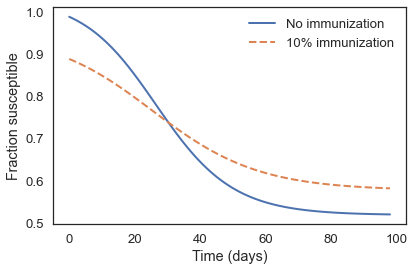

In [3]:
#code derived from chapter 12, allen
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction
    
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

results = run_simulation(system, update_func)
calc_total_infected(results)

system2 = make_system(beta, gamma)
add_immunization(system2, 0.1)
results2 = run_simulation(system2, update_func)
calc_total_infected(results2)

plot(results.S, '-', label='No immunization')
plot(results2.S, '--', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')


def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for fraction in immunize_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results)
        
    return sweep

immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)



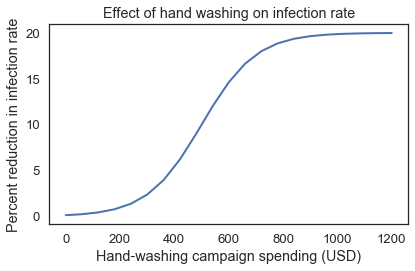

In [17]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

spending = linspace(0, 1200, 21)

def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

Exercise 2
      Modify the parameters M, K, and B, and see what effect they have on the shape of the curve. Read about the generalized logistic function on Wikipedia. Modify the other parameters and see what effect they have.

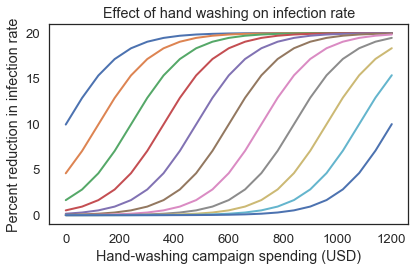

In [27]:
#create a function to cycle through optimal spend for campaigns
def cm_trans(spending,l):
    return logistic(spending, M=l, K=0.2, B=0.01)

def dif_m(spending):
    m=linspace(1,1200,11)
    for n in m:
        percent_reduction = cm_trans(spending,n) * 100
        plot(spending, percent_reduction)

        decorate(xlabel='Hand-washing campaign spending (USD)',
                 ylabel='Percent reduction in infection rate',
                 title='Effect of hand washing on infection rate',
                 legend=False)
dif_m(spending)

#All transition points start to converage around $500


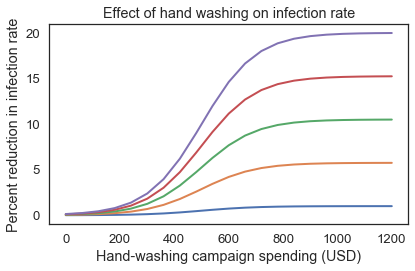

In [26]:
# Change in B, The most fesible reduction from Handwashing
def cm_beta(spending,n):
    return logistic(spending, M=500, K=n, B=0.01)

def dif_k():
    m=linspace(0.01,0.2,5)
    for n in m:
        percent_reduction = cm_beta(spending,n) * 100
        plot(spending, percent_reduction)

        decorate(xlabel='Hand-washing campaign spending (USD)',
                 ylabel='Percent reduction in infection rate',
                 title='Effect of hand washing on infection rate',
                 legend=False)
dif_k()
#all have slighty different M's now but spenind over $100 will result the sam3

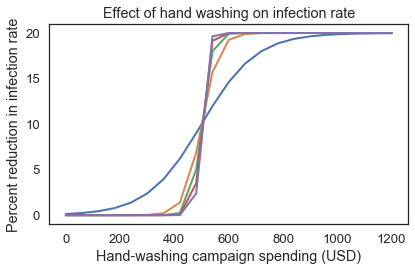

In [30]:
# Change in k, The maxiumn reduction from Handwashing
def cm_curve(spending,r):
    return logistic(spending, M=500, K=0.2, B=r)

def dif_b():
    m=linspace(0.01,0.1,5)
    for n in m:
        percent_reduction = cm_curve(spending,n) * 100
        plot(spending, percent_reduction)

        decorate(xlabel='Hand-washing campaign spending (USD)',
                 ylabel='Percent reduction in infection rate',
                 title='Effect of hand washing on infection rate',
                 legend=False)
dif_b()

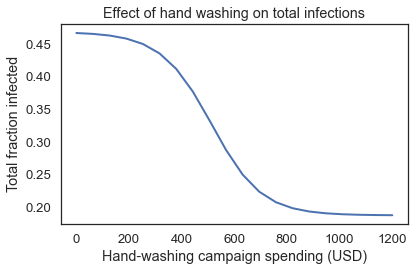

In [34]:
def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)
    
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

def sweep_hand_washing(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        results = run_simulation(system, update_func)
        sweep[spending] = calc_total_infected(results)
        
    return sweep

spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

plot(infected_sweep)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections',
         legend=False)


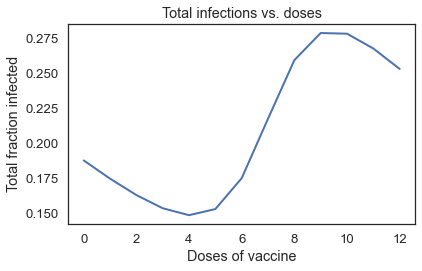

In [35]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses, endpoint=True)
max_doses

def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results)

    return sweep

infected_sweep = sweep_doses(dose_array)
plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses', 
         legend=False)

Exercise 3
    Suppose the price of the vaccine drops to $50 per dose. How does that affect the optimal allocation of the spending?

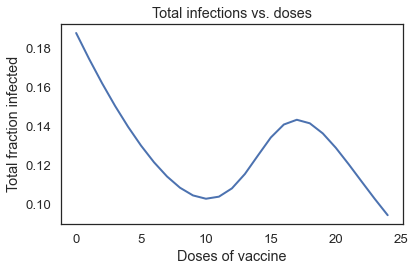

In [37]:
#running same sim with the reduced dose price
num_students = 90
budget = 1200
price_per_dose = 50
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses, endpoint=True)
max_doses


infected_sweep = sweep_doses(dose_array)
plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses', 
         legend=False)


It appears that doses after the 16th dropped the total infection rate. This can be interpeted as all the spend from hand washing was reallocated towards the vaccine prevention and herd immunity kept the infection rate low.

Exercise 4
            Suppose we have the option to quarantine infected students. For example, a student who feels ill might be moved to an infirmary, or a private dorm room, until they are no longer infectious.

In [ ]:
#create a quarantine functiom. % of the quarintine students cannot infect others
def add_quarantine(sytem,fraction):
        #reducing the infection rate as the student is quarantine in a closed space
        system.beta=sytem.beta*(fraction)
        